In [1]:
import os, sys, csv, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# change settings so that pandas will display 100 rows of data
pd.set_option('display.max_rows', 100)

In [3]:
grid_name = 'CISO'

grid_data_folder = 'grid-emissions'
weather_data_folder = 'weather-station-result'

In [4]:
grid_emissions_file_2019 = os.path.join(grid_data_folder, grid_name + '-' + '2019' + '.csv')
grid_emissions_file_2020 = os.path.join(grid_data_folder, grid_name + '-' + '2020' + '.csv')
grid_emissions_file_2021 = os.path.join(grid_data_folder, grid_name + '-' + '2021' + '.csv')

SF_weather_file_2019 = os.path.join(weather_data_folder, 'KSFO' + '-' + '2019' + '.csv')
SF_weather_file_2020 = os.path.join(weather_data_folder, 'KSFO' + '-' + '2020' + '.csv')
SF_weather_file_2021 = os.path.join(weather_data_folder, 'KSFO' + '-' + '2021' + '.csv')

LA_weather_file_2019 = os.path.join(weather_data_folder, 'KLAX' + '-' + '2019' + '.csv')
LA_weather_file_2020 = os.path.join(weather_data_folder, 'KLAX' + '-' + '2020' + '.csv')
LA_weather_file_2021 = os.path.join(weather_data_folder, 'KLAX' + '-' + '2021' + '.csv')

In [5]:
df_SF_weather_2019 = pd.read_csv(SF_weather_file_2019, usecols=['date_time', 'dry_bulb'])
df_SF_weather_2020 = pd.read_csv(SF_weather_file_2020, usecols=['date_time', 'dry_bulb'])
df_SF_weather_2021 = pd.read_csv(SF_weather_file_2021, usecols=['date_time', 'dry_bulb'])

df_LA_weather_2019 = pd.read_csv(LA_weather_file_2019, usecols=['date_time', 'dry_bulb'])
df_LA_weather_2020 = pd.read_csv(LA_weather_file_2020, usecols=['date_time', 'dry_bulb'])
df_LA_weather_2021 = pd.read_csv(LA_weather_file_2021, usecols=['date_time', 'dry_bulb'])

df_grid_emissions_2019 = pd.read_csv(grid_emissions_file_2019, usecols=['datetime_local', 'consumed_co2e_rate_kg_per_mwh_for_electricity'])
df_grid_emissions_2020 = pd.read_csv(grid_emissions_file_2020, usecols=['datetime_local', 'consumed_co2e_rate_kg_per_mwh_for_electricity'])
df_grid_emissions_2021 = pd.read_csv(grid_emissions_file_2021, usecols=['datetime_local', 'consumed_co2e_rate_kg_per_mwh_for_electricity'])

In [6]:
# remove leap day data from df_grid_emissions_2020 (since weather file removed it)
df_grid_emissions_2020 = df_grid_emissions_2020[~df_grid_emissions_2020['datetime_local'].str.contains('02-29')]

In [7]:
df_grid_emissions_2020.shape

(8760, 2)

In [8]:
df_SF_weather_3yrs = pd.concat([df_SF_weather_2019, df_SF_weather_2020, df_SF_weather_2021]).rename(columns={'dry_bulb': 'SF_temp'})
df_LA_weather_3yrs = pd.concat([df_LA_weather_2019, df_LA_weather_2020, df_LA_weather_2021]).rename(columns={'dry_bulb': 'LA_temp'})

df_CA_weather_3yrs = pd.merge(df_SF_weather_3yrs, df_LA_weather_3yrs, on='date_time')

In [9]:
# find the rows with null values
df_CA_weather_3yrs[df_CA_weather_3yrs.isnull().any(axis=1)]

,date_time,SF_temp,LA_temp
22106,2021-07-11-02:00,NaN,18.992308
22107,2021-07-11-03:00,NaN,18.023077
22108,2021-07-11-04:00,NaN,18.176923
22109,2021-07-11-05:00,NaN,18.800000
22110,2021-07-11-06:00,NaN,20.430769
22111,2021-07-11-07:00,NaN,21.130769
22112,2021-07-11-08:00,NaN,22.446154
22113,2021-07-11-09:00,NaN,22.792308
22114,2021-07-11-10:00,NaN,23.300000
22115,2021-07-11-11:00,NaN,23.530769


In [10]:
df_CA_weather_3yrs.isnull().sum()

date_time     0
SF_temp      12
LA_temp       0
dtype: int64

In [11]:
# interpolate the null values
df_CA_weather_3yrs[['SF_temp', 'LA_temp']] = df_CA_weather_3yrs[['SF_temp', 'LA_temp']].interpolate()

In [12]:
# convert date_time column to datetime type
df_CA_weather_3yrs['date_time'] = pd.to_datetime(df_CA_weather_3yrs['date_time'])
df_CA_weather_3yrs.reset_index(drop=True)
df_CA_weather_3yrs

,date_time,SF_temp,LA_temp
0,2019-01-01 00:00:00,10.661538,10.757143
1,2019-01-01 01:00:00,10.538462,10.238462
2,2019-01-01 02:00:00,9.876923,9.723077
3,2019-01-01 03:00:00,9.223077,7.930769
4,2019-01-01 04:00:00,8.561538,7.446154
...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923
26276,2021-12-31 20:00:00,8.992308,12.015385
26277,2021-12-31 21:00:00,8.253846,11.976923
26278,2021-12-31 22:00:00,8.684615,12.092308


In [13]:
df_CA_weather_3yrs.dtypes

date_time    datetime64[ns]
SF_temp             float64
LA_temp             float64
dtype: object

In [14]:
df_grid_emissions_3yrs = pd.concat([df_grid_emissions_2019, df_grid_emissions_2020, df_grid_emissions_2021]).rename(columns={'consumed_co2e_rate_kg_per_mwh_for_electricity': 'grid_emissions'})

In [15]:
# re-index df_grid_emissions_3yrs
df_grid_emissions_3yrs = df_grid_emissions_3yrs.reset_index(drop=True)
df_grid_emissions_3yrs

,datetime_local,grid_emissions
0,2019-01-01 00:00:00-08:00,308.79
1,2019-01-01 01:00:00-08:00,309.58
2,2019-01-01 02:00:00-08:00,314.50
3,2019-01-01 03:00:00-08:00,316.74
4,2019-01-01 04:00:00-08:00,316.34
...,...,...
26275,2021-12-31 19:00:00-08:00,273.29
26276,2021-12-31 20:00:00-08:00,277.30
26277,2021-12-31 21:00:00-08:00,277.92
26278,2021-12-31 22:00:00-08:00,266.93


In [16]:
df_combined_3yrs = pd.merge(df_CA_weather_3yrs, df_grid_emissions_3yrs, left_index=True, right_index=True).drop(columns=['datetime_local'])
df_combined_3yrs

,date_time,SF_temp,LA_temp,grid_emissions
0,2019-01-01 00:00:00,10.661538,10.757143,308.79
1,2019-01-01 01:00:00,10.538462,10.238462,309.58
2,2019-01-01 02:00:00,9.876923,9.723077,314.50
3,2019-01-01 03:00:00,9.223077,7.930769,316.74
4,2019-01-01 04:00:00,8.561538,7.446154,316.34
...,...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923,273.29
26276,2021-12-31 20:00:00,8.992308,12.015385,277.30
26277,2021-12-31 21:00:00,8.253846,11.976923,277.92
26278,2021-12-31 22:00:00,8.684615,12.092308,266.93


In [31]:
#create columns for month, day of week, and hour of day
df_combined_3yrs['month'] = df_combined_3yrs['date_time'].dt.month
df_combined_3yrs['day_of_week'] = df_combined_3yrs['date_time'].dt.dayofweek
df_combined_3yrs['hour_of_day'] = df_combined_3yrs['date_time'].dt.hour

# add a column for day of year
df_combined_3yrs['day_of_year'] = df_combined_3yrs['date_time'].dt.dayofyear

In [32]:
# create a column for weekend vs weekday
df_combined_3yrs['weekend'] = df_combined_3yrs['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df_combined_3yrs.head(100)

,date_time,SF_temp,LA_temp,grid_emissions,month,day_of_week,hour_of_day,weekend,day_of_year
0,2019-01-01 00:00:00,10.661538,10.757143,308.79,1,1,0,0,1
1,2019-01-01 01:00:00,10.538462,10.238462,309.58,1,1,1,0,1
2,2019-01-01 02:00:00,9.876923,9.723077,314.50,1,1,2,0,1
3,2019-01-01 03:00:00,9.223077,7.930769,316.74,1,1,3,0,1
4,2019-01-01 04:00:00,8.561538,7.446154,316.34,1,1,4,0,1
5,2019-01-01 05:00:00,8.376923,7.715385,317.50,1,1,5,0,1
6,2019-01-01 06:00:00,8.684615,6.130769,311.26,1,1,6,0,1
7,2019-01-01 07:00:00,8.484615,7.330769,311.23,1,1,7,0,1
8,2019-01-01 08:00:00,7.753846,9.030769,260.65,1,1,8,0,1
9,2019-01-01 09:00:00,8.023077,11.630769,185.08,1,1,9,0,1


In [165]:
df_combined_3yrs_withdummies = pd.get_dummies(df_combined_3yrs, columns=['month', 'day_of_week', 'hour_of_day'])

In [166]:
df_combined_3yrs_withdummies

,date_time,SF_temp,LA_temp,grid_emissions,month_1,month_2,month_3,month_4,month_5,month_6,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,2019-01-01 00:00:00,10.661538,10.757143,308.79,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 01:00:00,10.538462,10.238462,309.58,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 02:00:00,9.876923,9.723077,314.50,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-01 03:00:00,9.223077,7.930769,316.74,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-01 04:00:00,8.561538,7.446154,316.34,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923,273.29,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
26276,2021-12-31 20:00:00,8.992308,12.015385,277.30,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
26277,2021-12-31 21:00:00,8.253846,11.976923,277.92,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26278,2021-12-31 22:00:00,8.684615,12.092308,266.93,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [33]:
# create a new dataframe for data with year 2019 or 2020
df_combined_2019_2020 = df_combined_3yrs[df_combined_3yrs['date_time'].dt.year.isin([2019, 2020])].reset_index(drop=True)
# df_combined_2019_2020 = df_combined_3yrs_withdummies[df_combined_3yrs_withdummies['date_time'].dt.year.isin([2019, 2020])].reset_index(drop=True)

# create a new dataframe for data with year 2021
df_combined_2021 = df_combined_3yrs[df_combined_3yrs['date_time'].dt.year.isin([2021])].reset_index(drop=True)
# df_combined_2021 = df_combined_3yrs_withdummies[df_combined_3yrs_withdummies['date_time'].dt.year.isin([2021])].reset_index(drop=True)

In [34]:
df_combined_2019_2020.shape, df_combined_2021.shape

((17520, 9), (8760, 9))

In [35]:
df_combined_2019_2020

,date_time,SF_temp,LA_temp,grid_emissions,month,day_of_week,hour_of_day,weekend,day_of_year
0,2019-01-01 00:00:00,10.661538,10.757143,308.79,1,1,0,0,1
1,2019-01-01 01:00:00,10.538462,10.238462,309.58,1,1,1,0,1
2,2019-01-01 02:00:00,9.876923,9.723077,314.50,1,1,2,0,1
3,2019-01-01 03:00:00,9.223077,7.930769,316.74,1,1,3,0,1
4,2019-01-01 04:00:00,8.561538,7.446154,316.34,1,1,4,0,1
...,...,...,...,...,...,...,...,...,...
17515,2020-12-31 19:00:00,11.546154,15.769231,292.99,12,3,19,0,366
17516,2020-12-31 20:00:00,10.846154,15.000000,293.91,12,3,20,0,366
17517,2020-12-31 21:00:00,9.300000,14.569231,294.06,12,3,21,0,366
17518,2020-12-31 22:00:00,8.761538,14.069231,294.99,12,3,22,0,366


In [36]:
X_train = df_combined_2019_2020.drop(columns=['date_time', 'grid_emissions', 'day_of_week'])
y_train = df_combined_2019_2020['grid_emissions']

X_test = df_combined_2021.drop(columns=['date_time', 'grid_emissions', 'day_of_week'])
y_test = df_combined_2021['grid_emissions']

In [37]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [38]:
X_train

,SF_temp,LA_temp,month,hour_of_day,weekend,day_of_year
0,10.661538,10.757143,1,0,0,1
1,10.538462,10.238462,1,1,0,1
2,9.876923,9.723077,1,2,0,1
3,9.223077,7.930769,1,3,0,1
4,8.561538,7.446154,1,4,0,1
...,...,...,...,...,...,...
17515,11.546154,15.769231,12,19,0,366
17516,10.846154,15.000000,12,20,0,366
17517,9.300000,14.569231,12,21,0,366
17518,8.761538,14.069231,12,22,0,366


In [39]:
# use standard scalar on df_CA_weather_grid to scale columns 'SF_dry_bulb', 'LA_dry_bulb'
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['SF_temp', 'LA_temp', 'month', 'hour_of_day', 'day_of_year']] = scaler.fit_transform(X_train_scaled[['SF_temp', 'LA_temp', 'month', 'hour_of_day', 'day_of_year']])
X_test_scaled[['SF_temp', 'LA_temp', 'month', 'hour_of_day', 'day_of_year']] = scaler.transform(X_test_scaled[['SF_temp', 'LA_temp', 'month', 'hour_of_day', 'day_of_year']])

In [40]:
# get scaler mean and std
scaler_mean = scaler.mean_
scaler_std = scaler.scale_
scaler_mean, scaler_std

(array([ 14.79381011,  17.58368283,   6.5260274 ,  11.5       ,
        183.41917808]),
 array([  4.3586109 ,   4.08224107,   3.44785132,   6.92218655,
        105.48447741]))

In [41]:
X_train_scaled

,SF_temp,LA_temp,month,hour_of_day,weekend,day_of_year
0,-0.948071,-1.672253,-1.602745,-1.661325,0,-1.729346
1,-0.976308,-1.799311,-1.602745,-1.516862,0,-1.729346
2,-1.128086,-1.925561,-1.602745,-1.372399,0,-1.729346
3,-1.278098,-2.364611,-1.602745,-1.227936,0,-1.729346
4,-1.429876,-2.483324,-1.602745,-1.083473,0,-1.729346
...,...,...,...,...,...,...
17515,-0.745113,-0.444475,1.587648,1.083473,0,1.730879
17516,-0.905714,-0.632908,1.587648,1.227936,0,1.730879
17517,-1.260450,-0.738431,1.587648,1.372399,0,1.730879
17518,-1.383989,-0.860912,1.587648,1.516862,0,1.730879


In [42]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# predict
y_pred_train_linreg = linreg.predict(X_train_scaled)
y_pred_test_linreg = linreg.predict(X_test_scaled)

# MSE and RMSE
linreg_mse_train = mean_squared_error(y_train, y_pred_train_linreg)
linreg_mse_test = mean_squared_error(y_test, y_pred_test_linreg)
linreg_rmse_train = np.sqrt(linreg_mse_train)
linreg_rmse_test = np.sqrt(linreg_mse_test)

# r2 score
linreg_r2_train = r2_score(y_train, y_pred_train_linreg)
linreg_r2_test = r2_score(y_test, y_pred_test_linreg)

In [43]:
y_pred_train_linreg

array([226.49100552, 229.97153282, 234.92892952, ..., 324.38354168,
       328.9333312 , 336.86749424])

In [44]:
# Make a table of results for train and test errors
d = {'train': [linreg_mse_train, linreg_rmse_train, linreg_r2_train], 'test': [linreg_mse_test, linreg_rmse_test, linreg_r2_test]}
df_linreg_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Simple Multi-Linear Regression:')
df_linreg_results

Simple Multi-Linear Regression:


,train,test
MSE,3291.805381,2886.408992
RMSE,57.374257,53.725311
R2,0.262720,0.190073


In [47]:
# polynomial regression
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

polyreg = LinearRegression(fit_intercept=False)
polyreg.fit(X_train_poly, y_train)

# predict
y_pred_poly_train = polyreg.predict(X_train_poly)
y_pred_poly_test = polyreg.predict(X_test_poly)

# MSE and RMSE
polyreg_mse_train = mean_squared_error(y_train, y_pred_poly_train)
polyreg_rmse_train = np.sqrt(polyreg_mse_train)
polyreg_mse_test = mean_squared_error(y_test, y_pred_poly_test)
polyreg_rmse_test = np.sqrt(polyreg_mse_test)

# r2 score
polyreg_r2_train = r2_score(y_train, y_pred_poly_train)
polyreg_r2_test = r2_score(y_test, y_pred_poly_test)

In [48]:
# Make a table of results for train and test errors
d = {'train': [polyreg_mse_train, polyreg_rmse_train, polyreg_r2_train], 'test': [polyreg_mse_test, polyreg_rmse_test, polyreg_r2_test]}
df_polyreg_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Polynomial Regression (degree=2):')
df_polyreg_results

Polynomial Regression (degree=2):


,train,test
MSE,1770.499538,2160.458485
RMSE,42.077304,46.480732
R2,0.603453,0.393775


In [49]:
plt.figure(figsize=(20,10))

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

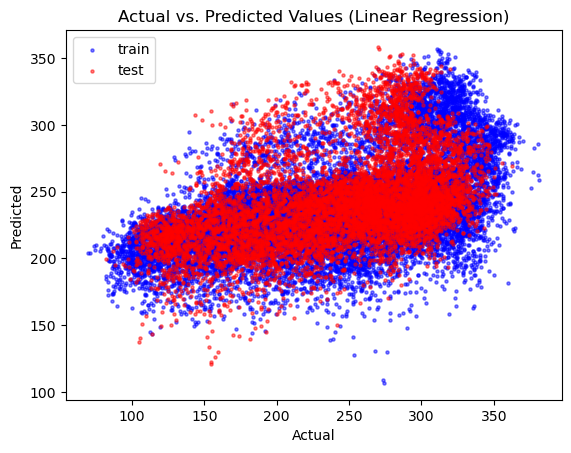

In [50]:
# plot actual vs predicted values for train and test sets
plt.scatter(y_train, y_pred_train_linreg, color='blue', label='train', s=5, alpha=.5)
plt.scatter(y_test, y_pred_test_linreg, color='red', label='test', s=5, alpha = .5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.legend()


In [55]:
# Ridge Regression
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train, y_train)

# predict
y_pred_train_ridge = ridge.predict(X_train)
y_pred_test_ridge = ridge.predict(X_test)

# MSE and RMSE
ridge_mse_train = mean_squared_error(y_train, y_pred_train_ridge)
ridge_rmse_train = np.sqrt(ridge_mse_train)
ridge_mse_test = mean_squared_error(y_test, y_pred_test_ridge)
ridge_rmse_test = np.sqrt(ridge_mse_test)

# r2 score
ridge_r2_train = r2_score(y_train, y_pred_train_ridge)
ridge_r2_test = r2_score(y_test, y_pred_test_ridge)


c:\Users\trent\.conda\envs\idep\Lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [56]:
# Make a table of results for train and test errors
d = {'train': [ridge_mse_train, ridge_rmse_train, ridge_r2_train], 'test': [ridge_mse_test, ridge_rmse_test, ridge_r2_test]}
df_ridge_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Ridge Regression:')
df_ridge_results

Ridge Regression:


,train,test
MSE,3299.124819,2856.84153
RMSE,57.438008,53.44943
R2,0.261081,0.19837


In [53]:
# Lasso Regression
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train_poly, y_train)

# predict
y_pred_train_lasso = lasso.predict(X_train_poly)
y_pred_test_lasso = lasso.predict(X_test_poly)

# MSE and RMSE
lasso_mse_train = mean_squared_error(y_train, y_pred_train_lasso)
lasso_rmse_train = np.sqrt(lasso_mse_train)
lasso_mse_test = mean_squared_error(y_test, y_pred_test_lasso)
lasso_rmse_test = np.sqrt(lasso_mse_test)

# r2 score
lasso_r2_train = r2_score(y_train, y_pred_train_lasso)
lasso_r2_test = r2_score(y_test, y_pred_test_lasso)


c:\Users\trent\.conda\envs\idep\Lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [54]:
# Make a table of results for train and test errors
d = {'train': [lasso_mse_train, lasso_rmse_train, lasso_r2_train], 'test': [lasso_mse_test, lasso_rmse_test, lasso_r2_test]}
df_lasso_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Lasso Regression:')
df_lasso_results

Lasso Regression:


,train,test
MSE,2699.537222,2363.610382
RMSE,51.957071,48.616976
R2,0.395373,0.336770


In [122]:
# use ridge regression on the polynomial features data
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train_poly, y_train)

# predict
y_pred_train_ridge_poly = ridge.predict(X_train_poly)
y_pred_test_ridge_poly = ridge.predict(X_test_poly)

# MSE and RMSE
ridge_mse_train_poly = mean_squared_error(y_train, y_pred_train_ridge_poly)
ridge_rmse_train_poly = np.sqrt(ridge_mse_train_poly)
ridge_mse_test_poly = mean_squared_error(y_test, y_pred_test_ridge_poly)
ridge_rmse_test_poly = np.sqrt(ridge_mse_test_poly)

# r2 score
ridge_r2_train_poly = r2_score(y_train, y_pred_train_ridge_poly)
ridge_r2_test_poly = r2_score(y_test, y_pred_test_ridge_poly)

c:\Users\trent\.conda\envs\idep\Lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [123]:
# Make a table of results for train and test errors
d = {'train': [ridge_mse_train_poly, ridge_rmse_train_poly, ridge_r2_train_poly], 'test': [ridge_mse_test_poly, ridge_rmse_test_poly, ridge_r2_test_poly]}
df_ridge_poly_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Ridge Regression (polynomial features):')
df_ridge_poly_results

Ridge Regression (polynomial features):


,train,test
MSE,480.682954,545.454481
RMSE,21.924483,23.354967
R2,0.897605,0.879883
